In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy

plt.style.use('ggplot')

In [2]:
# Connect to db
eng = nivapy.da.connect()

Connection successful.


# Check nitrate limit of detection values in ICPW database

Filip has pointed out that annual nitrate concentrations for Swedish sites (as shown on the [Explore Data]() page of the ICPW website) seem too low - well below the limit of detection for the lab performing the analysis. The lowest reported $NO_3^-$ values from the lab should be 10 µgN/l, which is 0.71 µeq/l. 

This notebook performs a quick check to see whether the problem is with the raw data in our database, or with my data processing and analysis for the website.  

# 1. Get Swedish stations

In [3]:
# Get projects table
prj_grid = nivapy.da.select_resa_projects(eng)
prj_grid

581 projects in the RESA database.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# Select project
prj_df = prj_grid.get_selected_df()
prj_df

,project_id,project_number,project_name,contact_person,project_description
469,2944,None,ICPWaters SE,None,None


In [5]:
# Get stations
stn_df = nivapy.da.select_resa_project_stations(prj_df, eng)
stn_df

,station_id,station_code,station_name,latitude,longitude,altitude
0,29290,SE13,Allgjuttern,57.948283,16.099441,NaN
1,29334,SE14,Remmarsjön,63.863089,18.276358,NaN
2,29335,SE15,Rotehogstjärnen,58.815478,11.614963,NaN
3,29341,SE17,Stora Skärsjön,56.671708,13.068004,NaN
4,29343,SE16,Stora Envättern,59.115419,17.356840,NaN
5,29371,SE18,Övre Skärsjön,59.837666,15.553400,NaN
6,23597,SE01,Delångersån Iggersund,61.636500,17.087167,0.0
7,23598,SE02,Alsterån Getebro,57.009000,16.159000,60.0
8,23600,SE05,Tväringen,62.240000,15.672500,308.0
9,23601,SE06,Stensjön,61.639500,15.904500,268.0


In [6]:
# Map
nivapy.spatial.quickmap(stn_df, popup='station_code')

## 2. Get NO3 data

In [7]:
# Get available params
st_dt = '1990-01-01'
end_dt = '2012-12-31'
par_grid = nivapy.da.select_resa_station_parameters(stn_df,
                                                    st_dt,
                                                    end_dt,
                                                    eng)
par_grid

33 parameters available for the selected stations and dates.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
# Select NO3
par_df = par_grid.get_selected_df()
par_df

,parameter_id,parameter_name,unit
18,5,NO3-N,µg/l N


In [9]:
# Get chem data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_df,
                                              par_df,
                                              st_dt,
                                              end_dt,
                                              eng,
                                              lod_flags=False)

# Get just surface samples
wc_df = wc_df.query('depth1 <= 1 and depth2 <= 1')

# Convert units to ueq/l
wc_df['NO3-N_µeq/l'] = wc_df['NO3-N_µg/l N']/14.

wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,NO3-N_µg/l N,NO3-N_µeq/l
,,,,,,,,
0,23597,SE01,Delångersån Iggersund,1990-01-23,0.0,0.0,151.0,10.785714
1,23597,SE01,Delångersån Iggersund,1990-02-26,0.0,0.0,222.0,15.857143
2,23597,SE01,Delångersån Iggersund,1990-03-26,0.0,0.0,226.0,16.142857
3,23597,SE01,Delångersån Iggersund,1990-04-23,0.0,0.0,186.0,13.285714
4,23597,SE01,Delångersån Iggersund,1990-05-30,0.0,0.0,68.0,4.857143


## 3. Stora Envättern example

Let's look at trends for one site (Stora Envättern, station code SE16), which has some fairly low concentrations.

In [10]:
# Get just data for Stensjön
sten_df = wc_df.query('station_code == "SE16"')
sten_df = sten_df[['sample_date', 'NO3-N_µeq/l']]
sten_df.set_index('sample_date', inplace=True)

# Resample to annual means
sten_df = sten_df.resample('A').median()
sten_df.index = sten_df.index.year

sten_df

,NO3-N_µeq/l
sample_date,
1990,0.500000
1991,0.785714
1992,1.285714
1993,0.392857
1994,0.750000
1995,1.857143
1996,1.750000
1997,0.428571
1998,0.571429


## 4. Trends

In [11]:
# Apply Sen's slope
res_df, sen_df = nivapy.stats.sens_slope(sten_df, 
                                         value_col='NO3-N_µeq/l',
                                         index_col=sten_df.index)
res_df

,description,value
sslp,Median slope estimate,-0.0162338
icpt,Estimated intercept,33.1981
lb,Lower bound on slope estimate at specified alpha,-0.0446429
ub,Upper bound on slope estimate at specified alpha,0.0119048
trend,Type of trend (if present),no trend


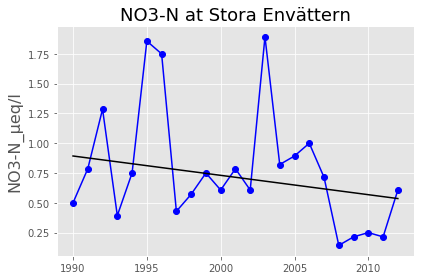

In [12]:
# Plot Sen's slope results
nivapy.plotting.plot_sens_slope(res_df, sen_df,
                                ylabel='NO3-N_µeq/l',
                                title='NO3-N at Stora Envättern')

This is the same as the plot on the website, so I think the code is working correctly. However, it is clear that our database has values well below 0.71 µeq/l. Looking at the raw data previously supplied to the ICPW programme, it looks as though the lowest values submitted are consistently 1 µeq/l (and not 10, which the the detection limit stated by Filip).